# Benchmarking Pipeline: Compare Baseline vs DWF Model
This notebook compares a fixed-incentive strategy against the DWF RL model using cancellation rate, incentives, and profitability.

In [2]:
# Load Libraries
import gym
import pandas as pd
import numpy as np
from stable_baselines3 import PPO
import matplotlib.pyplot as plt

In [3]:
# Load dataset
df = pd.read_csv("synthetic_ride_hailing_dataset.csv")
df.fillna(0, inplace=True)

In [4]:
import numpy as np

# Simulate realistic fares (e.g., between $8 and $15)
np.random.seed(45)
df['base_fare'] = np.random.uniform(8, 15, size=len(df))


In [5]:
df.head()

,Pickup Location,Request to Pickup,Hour of Day,Time of Day,Month of Year,Surge Pricing Indicator,DWF Reward Applied,Historical Demand Forecast,RPI,incentive,fare_adjustment,DPI,CR,base_fare
0,91,316.0,8,morning,1,1,0.00,0.656204,0.344730,1.047148,0.089986,0.013614,0.550500,14.923081
1,177,356.0,16,afternoon,10,0,0.00,0.381314,0.213189,0.545256,-0.051480,0.000000,0.580529,11.846813
2,80,556.0,3,night,8,0,3.12,0.132054,0.117240,0.789231,-0.082679,0.018303,0.607068,9.970131
3,196,423.0,17,evening,7,1,4.08,0.883895,0.138296,1.826744,-0.040154,0.017422,0.596100,8.541027
4,165,155.0,21,night,1,0,0.00,0.505134,0.879757,4.083967,-0.030278,0.006524,0.436169,11.111286


In [6]:
# Load PPO model (final version)
model = PPO.load("dwf_rl_pricing_model_v6")

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode only if not already encoded
if df['Time of Day'].dtype == 'object':
    df['Time of Day'] = LabelEncoder().fit_transform(df['Time of Day'])

if df['Month of Year'].dtype == 'object':
    df['Month of Year'] = LabelEncoder().fit_transform(df['Month of Year'])

if df['Pickup Location'].dtype == 'object':
    df['Pickup Location'] = LabelEncoder().fit_transform(df['Pickup Location'])


In [8]:
# PPO Policy Inference
ppo_actions = []
for _, row in df.iterrows():
    obs = np.array([
        row['Pickup Location'],
        row['Request to Pickup'],
        row['Time of Day'],
        row['Month of Year'],
        row['RPI'],
        row['DPI'],
        row['CR'],
        row['Historical Demand Forecast']
    ], dtype=np.float32)
    action, _ = model.predict(obs, deterministic=True)
    ppo_actions.append(action)

In [9]:
# Split PPO actions
ppo_fare_adjust, ppo_incentives = zip(*ppo_actions)
df['ppo_fare_adjust'] = ppo_fare_adjust
df['ppo_incentive'] = ppo_incentives

# 📏 Rule-Based Strategy: $2 incentive if pickup delay > 300s
df['rule_incentive'] = df['Request to Pickup'].apply(lambda x: 2.0 if x > 300 else 0.0)

# 🚦Define CR-based Completion
df['pickup_success'] = (df['CR'] < 0.5).astype(int)



In [10]:
# Rule-Based Strategy: $2 incentive if pickup delay > 300s
df['rule_incentive'] = df['Request to Pickup'].apply(lambda x: 2.0 if x > 300 else 0.0)

In [11]:
# Define CR-based Completion
df['pickup_success'] = (df['CR'] < 0.5).astype(int)

In [12]:
# Enhanced Evaluation using per-ride base_fare
def evaluate(strategy_name, incentive_col, is_rl=False, fare_adjust_col=None):
    completion = df['pickup_success'].mean()
    avg_incentive = df[incentive_col].mean()
    total_incentive = df[incentive_col].sum()

    if is_rl and fare_adjust_col:
        df['adjusted_fare'] = df['base_fare'] - df[fare_adjust_col]
        total_adjusted_fare = df['adjusted_fare'].sum()
        total_base_fare = df['base_fare'].sum()
        fare_loss = total_base_fare - total_adjusted_fare
        total_cost = total_incentive + fare_loss
    else:
        total_cost = total_incentive

    cost_per_success = total_cost / df['pickup_success'].sum()

    print(f"{strategy_name} Completion Rate: {completion:.2f}")
    print(f"{strategy_name} Avg Incentive: ${avg_incentive:.2f}")
    print(f"{strategy_name} Total Cost: ${total_cost:.2f}")
    print(f"{strategy_name} Cost per Successful Ride: ${cost_per_success:.2f}")
    print("")


In [13]:
# Rule-based strategy evaluation
evaluate("Rule-Based", incentive_col='rule_incentive')

# PPO (RL) strategy evaluation
evaluate("PPO (RL)", incentive_col='ppo_incentive', is_rl=True, fare_adjust_col='ppo_fare_adjust')


Rule-Based Completion Rate: 0.43
Rule-Based Avg Incentive: $0.77
Rule-Based Total Cost: $38584.00
Rule-Based Cost per Successful Ride: $1.78

PPO (RL) Completion Rate: 0.43
PPO (RL) Avg Incentive: $0.02
PPO (RL) Total Cost: $8384.03
PPO (RL) Cost per Successful Ride: $0.39



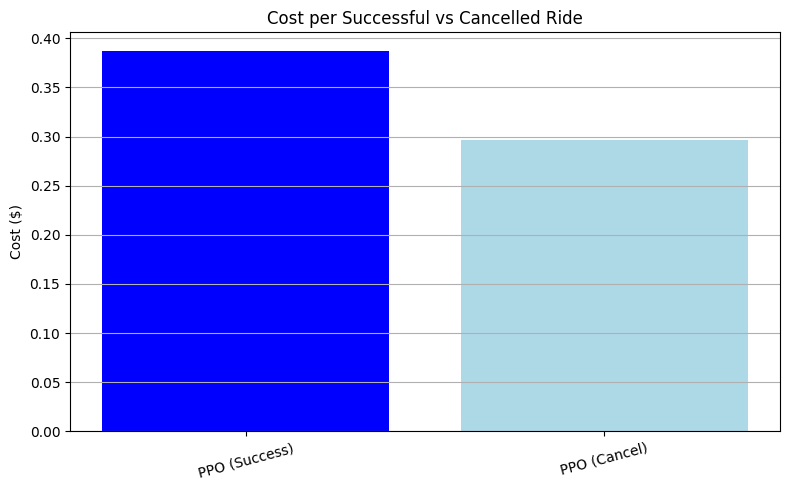

In [14]:
# Total Cost per Successful & Cancelled Ride Comparison

# PPO adjusted fare
ppo_adjusted_fare = df['base_fare'] - df['ppo_fare_adjust']
fare_loss = df['base_fare'].sum() - ppo_adjusted_fare.sum()

# Total cost calculations
ppo_total_cost = df['ppo_incentive'].sum() + fare_loss

# Count metrics
successful_rides = df['pickup_success'].sum()
cancelled_rides = len(df) - successful_rides

# Per-ride cost calculations
ppo_cost_success = ppo_total_cost / successful_rides
ppo_cost_cancel = ppo_total_cost / cancelled_rides

# Plot
import matplotlib.pyplot as plt

labels = ['PPO (Success)',  'PPO (Cancel)']
costs = [ppo_cost_success, ppo_cost_cancel]
colors = ['blue', 'lightblue']

plt.figure(figsize=(8, 5))
plt.bar(labels, costs, color=colors)
plt.title("Cost per Successful vs Cancelled Ride")
plt.ylabel("Cost ($)")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


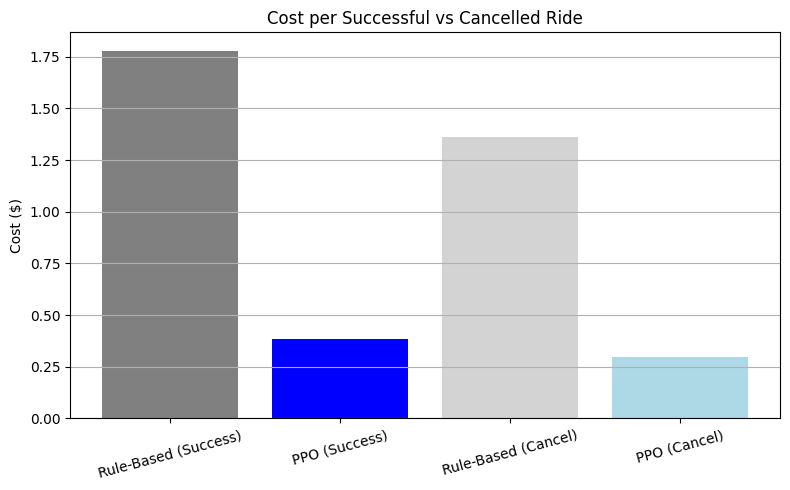

In [15]:
# Total Cost per Successful & Cancelled Ride Comparison

# PPO adjusted fare
ppo_adjusted_fare = df['base_fare'] - df['ppo_fare_adjust']
fare_loss = df['base_fare'].sum() - ppo_adjusted_fare.sum()

# Total cost calculations
rule_total_cost = df['rule_incentive'].sum()
ppo_total_cost = df['ppo_incentive'].sum() + fare_loss

# Count metrics
successful_rides = df['pickup_success'].sum()
cancelled_rides = len(df) - successful_rides

# Per-ride cost calculations
rule_cost_success = rule_total_cost / successful_rides
ppo_cost_success = ppo_total_cost / successful_rides

rule_cost_cancel = rule_total_cost / cancelled_rides
ppo_cost_cancel = ppo_total_cost / cancelled_rides

# Plot
import matplotlib.pyplot as plt

labels = ['Rule-Based (Success)', 'PPO (Success)', 'Rule-Based (Cancel)', 'PPO (Cancel)']
costs = [rule_cost_success, ppo_cost_success, rule_cost_cancel, ppo_cost_cancel]
colors = ['gray', 'blue', 'lightgray', 'lightblue']

plt.figure(figsize=(8, 5))
plt.bar(labels, costs, color=colors)
plt.title("Cost per Successful vs Cancelled Ride")
plt.ylabel("Cost ($)")
plt.xticks(rotation=15)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Hypothesis Testing

In [16]:
# Base fare already assigned
df['ppo_adjusted_fare'] = df['base_fare'] - df['ppo_fare_adjust']

# Per-ride costs
df['ppo_total_cost'] = df['ppo_incentive'] + (df['base_fare'] - df['ppo_adjusted_fare'])
df['rule_total_cost'] = df['rule_incentive']  # rule-based doesn't affect fare


In [17]:
from scipy.stats import ttest_ind

# Filter only successful rides
successful_df = df[df['pickup_success'] == 1]

# Create cost samples
ppo_costs = successful_df['ppo_total_cost']
rule_costs = successful_df['rule_total_cost']



In [18]:
from scipy.stats import mannwhitneyu

u_stat, p_value = mannwhitneyu(ppo_costs, rule_costs, alternative='two-sided')

print(f"Mann–Whitney U Test Result")
print(f"U-statistic: {u_stat}")
print(f"p-value: {p_value:.10f}")

if p_value < 0.05:
    print("Significant difference in cost per successful ride (reject H₀)")
else:
    print("No significant difference in cost per successful ride (fail to reject H₀)")


Mann–Whitney U Test Result
U-statistic: 468157744.0
p-value: 0.0000000000
Significant difference in cost per successful ride (reject H₀)


In [19]:
print(successful_df['ppo_total_cost'].describe())
print(successful_df['rule_total_cost'].describe())


count    21682.000000
mean         0.158148
std          0.042333
min         -0.150000
25%          0.150000
50%          0.150000
75%          0.150000
max          0.371144
Name: ppo_total_cost, dtype: float64
count    21682.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: rule_total_cost, dtype: float64
